In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import math
from matplotlib.collections import PatchCollection

In [2]:
info = pd.read_csv("data/env_info.csv")
#info['num_of_birds'][0]

## Episodes learning

In [3]:
#TODO: output a file with general info about the simulation so that we know the number of birds considered a priori
#plt.style.available
plt.style.use('ggplot')

def plot_episode():
    info = pd.read_csv("data/env_info.csv")
    num_birds=info['num_of_birds'][0]
    episode_lenght=info['episodes_length'][0]
    df = pd.read_csv("data/episode.csv")
    df["NormEndTime"] = df["EndTime"] / episode_lenght
    df["mean_norm_end"] = df["NormEndTime"] .rolling(100, min_periods=5).mean()
    #print(df)
    pred_train = df["PredatorTraining"]
    learner_change = np.where(np.roll(pred_train, -1) != pred_train)[0]
    ax = df.plot(x="Episode", y="mean_norm_end", kind="line", lw=0.5, legend=False, figsize=(16,9))
    ax.set_ylabel("EndTime")
    for i, x_l in enumerate(learner_change):
        if i%2 == 0:
            ax.axvline(x=x_l, color="red", linestyle='--', lw=1)
        else:
            ax.axvline(x=x_l, color="blue", linestyle='--', lw=1)

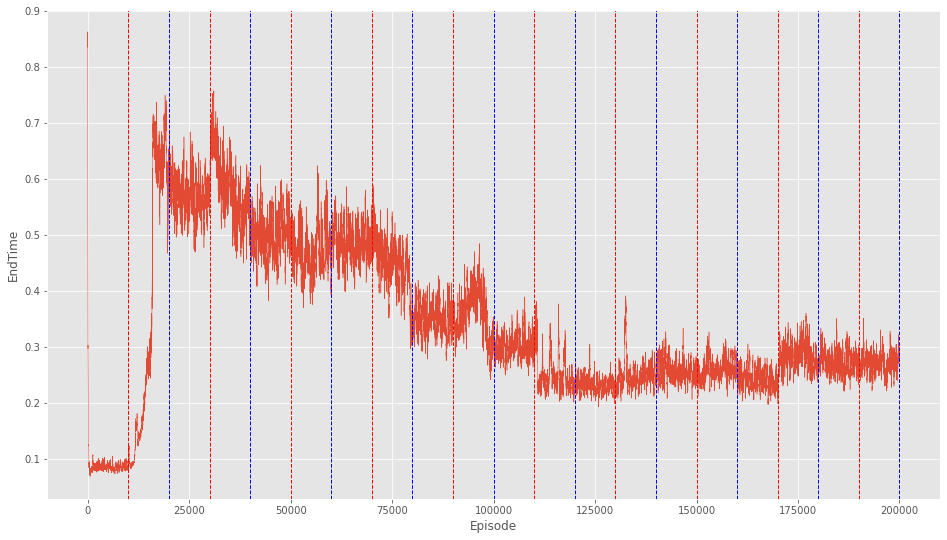

In [4]:
plot_episode()